# Chunk Size Guide

## Overview
When Featuretools calculates a feature matrix, it first groups the rows to be calculated into chunks. Each chunk is a collection of rows that will be computed at the same time. The results of calculating each chunk are combined into the single feature matrix that is returned to the user. The size of these chunks is determined by the `chunk_size` parameter, found in `dfs` and `calculate_feature_matrix`. If you wish to optimize chunk size, picking the right value will depend on the memory you have available and how often you’d like to get progress updates. This guide will go over a few example scenarios for choosing a good `chunk_size` and the factors to consider when doing so.

![](../images/chunk_size_graph.png "Chunk size versus calculation time")

### Peak memory usage
If rows have the same cutoff time they are placed in the same chunk until the chunk is full, so they can be calculated simultaneously. By increasing the size of a chunk, it is more likely that there is room for all rows for a given cutoff time to be grouped together. This allows us to minimize the overhead of finding allowable data. The downside is that computation now requires more memory per chunk. If the machine in use can’t handle the larger peak memory usage this can start to slow down the process more than the time saved by removing the overhead.

### Frequency of progress updates and overall runtime
After the completion of a chunk, there is a progress update along with an estimation of remaining compute time provided to the user. Smaller chunks mean more fine-grained updates to the user. Even more, the average runtime over many smaller chunks is a better estimate of the overall remaining runtime.

However, if we make the chunk size too small, we may split up rows that share the same cutoff time into separate chunks. This means Featuretools will have to slice the data for that cutoff time multiple times, resulting in repeated work. Additionally, if chunks get really small (e.g. one row per chunk), then the overhead from other parts of the calculation process will start to contribute more significantly to overall runtime.

### The `chunk_size` parameter
The size of each chunk is determined by the `chunk_size` parameter  in `dfs` or `calculate_feature_matrix`.  Valid inputs are:

* `None` or unspecified

```
# not specified, so default option
# uses 10% of rows per chunk
# if total rows is less than 100, chunk size is 10
fm = ft.calculate_feature_matrix(features)

# None is the default option
# same as above, 10% of rows per chunk or 10 rows per chunk, whichever is larger
fm = ft.calculate_feature_matrix(features, chunk_size=None)
```

* A positive integer

```
# 25 rows per chunk
fm = ft.calculate_feature_matrix(features, chunk_size=25)
```

* A float between 0 and 1 (percentage)

```
# 5% of all rows per chunk
fm = ft.calculate_feature_matrix(features, chunk_size=.05)
```

* The string "cutoff time" 

```
# use one chunk per unique cutoff time
fm = ft.calculate_feature_matrix(features, chunk_size="cutoff time")
```

Unlike the other options, "cutoff time" does not genereate a specific number of rows per chunk.  Instead of trying to create uniformly sized chunks, Featuretools will calculate every row with the same time together. 

### Instacart Dataset

This example makes use the Instacart dataset seen in the [Predict Next Purchase demo](https://github.com/featuretools/predict_next_purchase). Sets of labels and cutoff times are made at 3 month increments, but due to the nature of the data the first set of cutoff times accounts for nearly half of all rows in the cutoff time dataframe. Both the single chunk and cutoff time chunking scenarios will load all of that data in a single slice.  As we can see by comparing the single chunk or grouping by cutoff time cases with the smaller chunk size cases, keeping the entire cutoff time group together slows down the computation on this computer (4 cores @ 2.50 GHz, 8 GB RAM). Smaller chunk sizes than the default 10% lead to faster run times at first, continuing to reduce the size of each chunk starts to slow down the computation again. 

In [1]:
import time
import datetime

import featuretools as ft
import matplotlib.ticker as ticker
import pandas as pd
import seaborn
from featuretools.computational_backends import bin_cutoff_times


# assign locator and formatter for the xaxis ticks.
def timeTicks(x, pos):                                                                                                                                                                                                                                                         
    d = datetime.timedelta(seconds=x / 1000000000. )                                                                                                                                                                                                                                          
    return str(d)                                                                                                                                                                                                                                                              
formatter = ticker.FuncFormatter(timeTicks)

In [2]:
import utils

# import entityset
instacart_es = utils.load_entityset("partitioned_data/part_1/")

# make labels and cutoff times
label_times = pd.concat([utils.make_labels(es=instacart_es,
                                           product_name = "Banana",
                                           cutoff_time = pd.Timestamp('March 15, 2015'),
                                           prediction_window = ft.Timedelta("4 weeks"),
                                           training_window = ft.Timedelta("60 days")),
                         utils.make_labels(es=instacart_es,
                                           product_name = "Banana",
                                           cutoff_time = pd.Timestamp('June 15, 2015'),
                                           prediction_window = ft.Timedelta("4 weeks"),
                                           training_window = ft.Timedelta("60 days")),
                         utils.make_labels(es=instacart_es,
                                           product_name = "Banana",
                                           cutoff_time = pd.Timestamp('September 15, 2015'),
                                           prediction_window = ft.Timedelta("4 weeks"),
                                           training_window = ft.Timedelta("60 days")),
                         utils.make_labels(es=instacart_es,
                                           product_name = "Banana",
                                           cutoff_time = pd.Timestamp('December 15, 2015'),
                                           prediction_window = ft.Timedelta("4 weeks"),
                                           training_window = ft.Timedelta("60 days")),],
                       ignore_index=True)

print(label_times.groupby('time').count())

            user_id  label
time                      
2015-03-15     7790   7790
2015-06-15     4458   4458
2015-09-15     2515   2515
2015-12-15     1091   1091


#### 1 chunk

In [3]:
start = time.time()
feature_matrix, features = ft.dfs(target_entity="users", 
                                  cutoff_time=label_times,
                                  training_window=ft.Timedelta("60 days"),
                                  entityset=instacart_es,
                                  chunk_size=15854,
                                  verbose=True)
stop = time.time()
one_chunk_duration_4 = datetime.timedelta(seconds=stop-start)

Built 76 features
Elapsed: 04:20 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 1/1 chunks


#### 10% per chunk

In [4]:
start = time.time()
feature_matrix, features = ft.dfs(target_entity="users", 
                                  cutoff_time=label_times,
                                  training_window=ft.Timedelta("60 days"),
                                  entityset=instacart_es,
                                  verbose=True)
stop = time.time()
default_duration_4 = datetime.timedelta(seconds=stop-start)

Built 76 features
Elapsed: 03:18 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### 5% per chunk

In [5]:
start = time.time()
feature_matrix, features = ft.dfs(target_entity="users", 
                                  cutoff_time=label_times,
                                  training_window=ft.Timedelta("60 days"),
                                  entityset=instacart_es,
                                  chunk_size=.05,
                                  verbose=True)
stop = time.time()
five_percent_per_chunk_duration = datetime.timedelta(seconds=stop-start)

Built 76 features
Elapsed: 03:10 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 21/21 chunks


#### 2.5% per chunk

In [6]:
start = time.time()
feature_matrix, features = ft.dfs(target_entity="users", 
                                  cutoff_time=label_times,
                                  training_window=ft.Timedelta("60 days"),
                                  entityset=instacart_es,
                                  chunk_size=.025,
                                  verbose=True)
stop = time.time()
two_point_five_per_chunk_duration = datetime.timedelta(seconds=stop-start)

Built 76 features
Elapsed: 03:09 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 41/41 chunks


#### 1% per chunk

In [7]:
start = time.time()
feature_matrix, features = ft.dfs(target_entity="users", 
                                  cutoff_time=label_times,
                                  training_window=ft.Timedelta("60 days"),
                                  entityset=instacart_es,
                                  chunk_size=.01,
                                  verbose=True)
stop = time.time()
one_percent_per_chunk_duration = datetime.timedelta(seconds=stop-start)

Built 76 features
Elapsed: 03:24 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 101/101 chunks


#### "cutoff time" option

In [8]:
start = time.time()
feature_matrix, features = ft.dfs(target_entity="users", 
                                  cutoff_time=label_times,
                                  training_window=ft.Timedelta("60 days"),
                                  entityset=instacart_es,
                                  chunk_size="cutoff time",
                                  verbose=True)
stop = time.time()
cutoff_duration_4 = datetime.timedelta(seconds=stop-start)

Built 76 features
Elapsed: 04:20 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 4/4 chunks


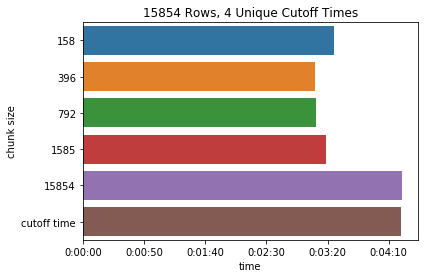

In [9]:
results_df_4 = pd.DataFrame({'time': [one_percent_per_chunk_duration,
                                      two_point_five_per_chunk_duration,
                                      five_percent_per_chunk_duration,
                                      default_duration_4,
                                      one_chunk_duration_4,
                                      cutoff_duration_4],
                           'chunk size': ['158', '396', '792', '1585', '15854', 'cutoff time']})
ax = seaborn.barplot(x='time', y='chunk size', data=results_df_4)
ax.set_title("15854 Rows, 4 Unique Cutoff Times")
ax.xaxis.set_major_formatter(formatter)

#### Summary 

In review, featuretools uses a parameter `chunk_size` to divide up the instances when calculating features.  Creating chunks that have the right amount of data can speed up calculations. If you need to speed up calculations, experimenting with different chunk sizes on a subset of the data before calculating on all the data can help find the best size.   